# 0. Setup

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import shap

from data_enginerring.targets_set import TARGETS, TargetSet
from data_enginerring.feature_set import STATIC_FEATURES, MICROSTRUCTURE_FEATURES, DeltasFeatureSet


shap.initjs()

SEED = 67
random.seed(SEED)
np.random.seed(SEED)

# 1. Data

## 1. Loading and Pre-processing

In [30]:
dataset_benchmark = pd.read_csv("data/dataset_benchmark.csv", parse_dates=["first_trade_time"])
dataset_expanded = pd.read_csv("data/dataset_expanded.csv", parse_dates=["first_trade_time"])
assert len(dataset_benchmark) == len(dataset_expanded), "Mismatch in tokens included."

def pool_type_identification(x):
    return int(x == "675kPX9MHTjS2zt1qfr1NYHuzeLXfQM9H24wFSUt1Mp8")
dataset_benchmark["pool_type"] = dataset_benchmark["pool_type"].transform(pool_type_identification)
dataset_expanded["pool_type"] = dataset_expanded["pool_type"].transform(pool_type_identification)

dataset_benchmark = dataset_benchmark.sort_values(['first_trade_time', 'token_mint']).set_index('first_trade_time')
dataset_expanded = dataset_expanded.sort_values(['first_trade_time', 'token_mint']).set_index('first_trade_time')

dataset_expanded.head()

,token_mint,pool_type,has_pumpdotfun_history,token_decimals,n_transfers,n_swaps,n_buys,n_lp_addition_like,n_lp_removal_like,buy_percentage,...,kyle_lambda,roll_spread,roll_percentage_spread,amihud_illiquidity,vpin,md_price_no_post_rc_0.9_0.01,md_price_no_post_rc_0.99_0.005,md_liq_no_post_rc_0.99_0.01,md_liq_0.9,idle_300
first_trade_time,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:31+00:00,3wii3WDRkhScqZvp3q3QvUNPr4w34QF4ydQTbnE5ytKm,1,0,6,382,381,294,1,0,0.769634,...,0.048559,-1802.050086,-7.630116,8.682559e+03,0.516330,1,1,1,1,1
2024-10-01 00:01:13+00:00,HumFbCWH77CiYuwVFV163RYB9Fa7vxqKCCPsz9gspump,1,1,6,600,599,313,1,0,0.521667,...,0.003868,48.157616,0.917897,2.514349e+04,0.427266,1,0,0,0,0
2024-10-01 00:11:09+00:00,2vrTSA71k2JnbT7VdyHqGcyjBNvncHcLPuECPXbUzLkp,1,0,6,159,158,108,1,0,0.679245,...,0.007659,-5827.446046,-88.979381,9.978782e+03,0.997319,0,0,0,0,0
2024-10-01 00:13:18+00:00,7NkeDHRC9ERbZ79ca3hkGvr1UDF2VnAPjNqw81tt4CK5,1,0,6,627,626,444,1,0,0.708134,...,921.830877,-388299.439415,-15.663166,6.692039e+03,0.994968,1,1,1,1,1
2024-10-01 00:14:58+00:00,E7NvJPn2HGvYbqJAKpTNC4spozq9gngQFDkCfVRdkUM6,1,0,9,729,727,131,1,1,0.179698,...,0.005655,-99.042811,NaN,3.668076e+10,0.974120,0,0,1,1,1


In [31]:
meta_columns = ["token_mint", "first_trade_time"]
targets = TargetSet(TARGETS).targets_list
features_benchmark = [c for c in dataset_benchmark.columns if c not in meta_columns + targets]
features_expanded = [c for c in dataset_expanded.columns if c not in meta_columns + targets]

X_bench = dataset_benchmark[features_benchmark]
X_exp = dataset_expanded[features_expanded]
y = dataset_benchmark[targets]

## 1.2. Data Exploration

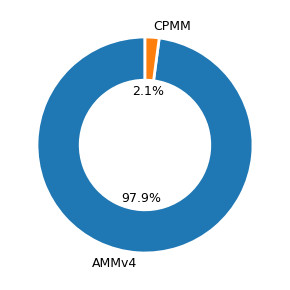

In [32]:
counts = X_bench.groupby("pool_type").pool_type.count().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(6, 3))
ax.pie(counts, labels=["AMMv4", "CPMM"],
       autopct="%1.1f%%", pctdistance=0.5, startangle=90,
       wedgeprops=dict(edgecolor="white", linewidth=2, width=0.4),
       textprops=dict(fontsize=9))
plt.tight_layout()
plt.show()

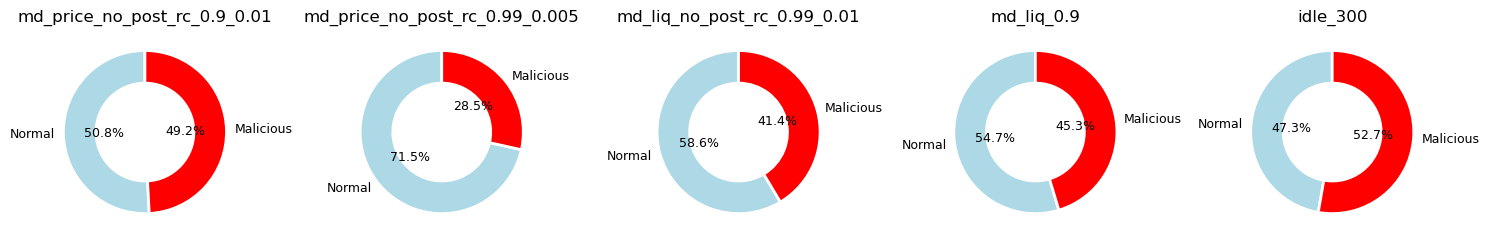

In [33]:
n_targets = len(targets)
fig, ax = plt.subplots(1, n_targets, figsize=(n_targets * 3, 3))

colors = ["lightblue", "red"]
labels = ["Normal", "Malicious"]

for i, target in enumerate(targets):
    counts = y[target].value_counts().sort_index()
    ax[i].pie(counts, labels=labels, colors=colors,
              autopct="%1.1f%%", pctdistance=0.5, startangle=90,            # include percentage
              wedgeprops=dict(edgecolor="white", linewidth=2, width=0.4),   # "donut" plot
              textprops=dict(fontsize=9))
    ax[i].set_title(target)
plt.tight_layout()
plt.show()

# 2. Basic A/B Test: Model with Default Specifications

In [34]:
start_test = '2024-11-01'
train_idx, test_idx = dataset_benchmark.index < start_test, dataset_benchmark.index >= start_test

X_bench_train, X_exp_train, y_train = X_bench[train_idx], X_exp[train_idx], y[train_idx]
X_bench_test, X_exp_test, y_test = X_bench[test_idx], X_exp[test_idx], y[test_idx]
X_exp_train.head()

,pool_type,has_pumpdotfun_history,token_decimals,n_transfers,n_swaps,n_buys,n_lp_addition_like,n_lp_removal_like,buy_percentage,sell_percentage,...,first_sell_rel_ts,avg_rsi_6,std_rsi_6,avg_rsi_12,std_rsi_12,kyle_lambda,roll_spread,roll_percentage_spread,amihud_illiquidity,vpin
first_trade_time,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:31+00:00,1,0,6,382,381,294,1,0,0.769634,0.227749,...,24.0,54.943875,10.322659,54.146780,5.224459,0.048559,-1802.050086,-7.630116,8.682559e+03,0.516330
2024-10-01 00:01:13+00:00,1,1,6,600,599,313,1,0,0.521667,0.476667,...,2.0,44.483709,19.165070,47.405397,11.957105,0.003868,48.157616,0.917897,2.514349e+04,0.427266
2024-10-01 00:11:09+00:00,1,0,6,159,158,108,1,0,0.679245,0.314465,...,1.0,54.781867,5.880839,58.270899,0.608321,0.007659,-5827.446046,-88.979381,9.978782e+03,0.997319
2024-10-01 00:13:18+00:00,1,0,6,627,626,444,1,0,0.708134,0.290271,...,4.0,49.661232,11.020860,50.070581,5.639549,921.830877,-388299.439415,-15.663166,6.692039e+03,0.994968
2024-10-01 00:14:58+00:00,1,0,9,729,727,131,1,1,0.179698,0.817558,...,42.0,55.626619,28.892618,44.614102,19.053823,0.005655,-99.042811,NaN,3.668076e+10,0.974120


## 2.1. Catboost

Here and futher on the SHAP beeswarm plot is made for the expanded model only.

md_price_no_post_rc_0.9_0.01
[Benchmark]
Already trained.
	ROC AUC	= 0.8720074378467231
	PR AUC	= 0.8773151239317312
	F1	= 0.7859888936351986
[Expanded]
Already trained.
	ROC AUC	= 0.8722997328950073
	PR AUC	= 0.8779633268649842
	F1	= 0.783979548359608
p-value of difference in:
	ROC AUC	= 0.7292126772789606
	PR AUC	= 0.4657
	F1	= 0.3774


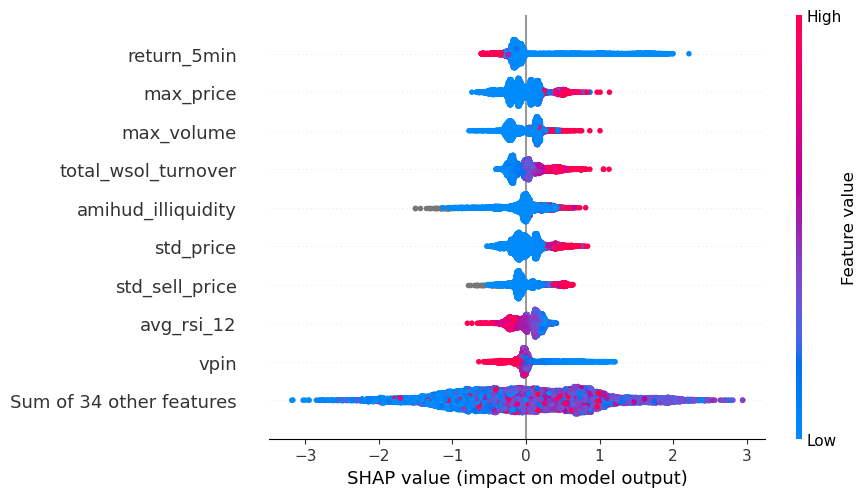

md_price_no_post_rc_0.99_0.005
[Benchmark]
Already trained.
	ROC AUC	= 0.9428771320513707
	PR AUC	= 0.8702567465266771
	F1	= 0.7937880872813053
[Expanded]
Already trained.
	ROC AUC	= 0.9449667069464901
	PR AUC	= 0.8733379839756733
	F1	= 0.7960023515579071
p-value of difference in:
	ROC AUC	= 0.00014541812041061076
	PR AUC	= 0.0274
	F1	= 0.4425


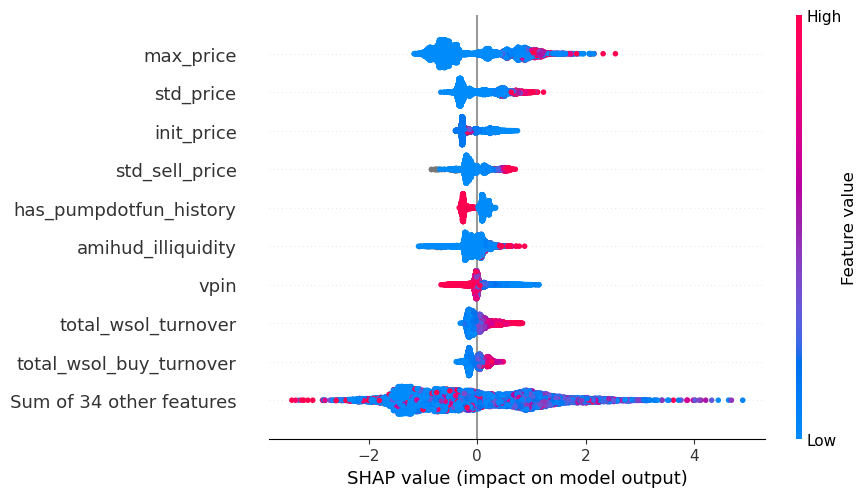

md_liq_no_post_rc_0.99_0.01
[Benchmark]
Already trained.
	ROC AUC	= 0.9694233360104911
	PR AUC	= 0.9478835235921078
	F1	= 0.8702817650186071
[Expanded]
Already trained.
	ROC AUC	= 0.9686764195633109
	PR AUC	= 0.9466656242905955
	F1	= 0.8688939172101691
p-value of difference in:
	ROC AUC	= 0.04166345377071563
	PR AUC	= 0.0628
	F1	= 0.5082


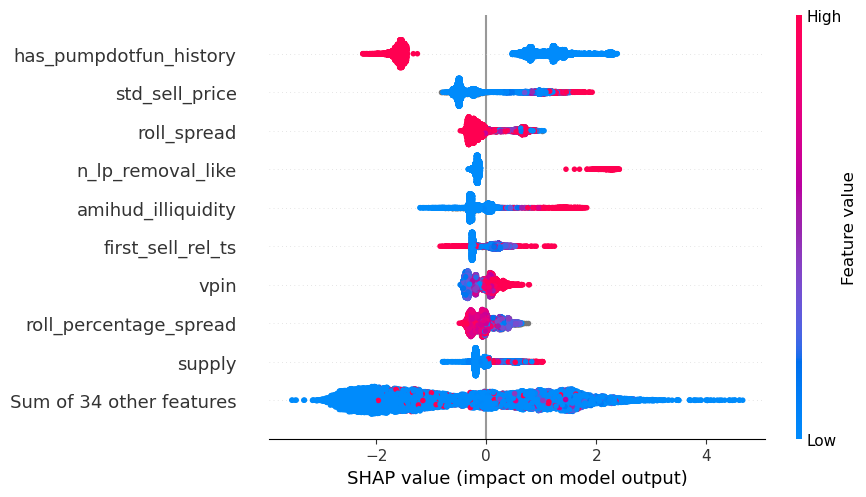

md_liq_0.9
[Benchmark]
Already trained.
	ROC AUC	= 0.9616769173703263
	PR AUC	= 0.9478141074255613
	F1	= 0.8664573774450616
[Expanded]
Already trained.
	ROC AUC	= 0.9617404226890239
	PR AUC	= 0.9478470366968168
	F1	= 0.8627830931330992
p-value of difference in:
	ROC AUC	= 0.8854981116485787
	PR AUC	= 0.9539
	F1	= 0.0818


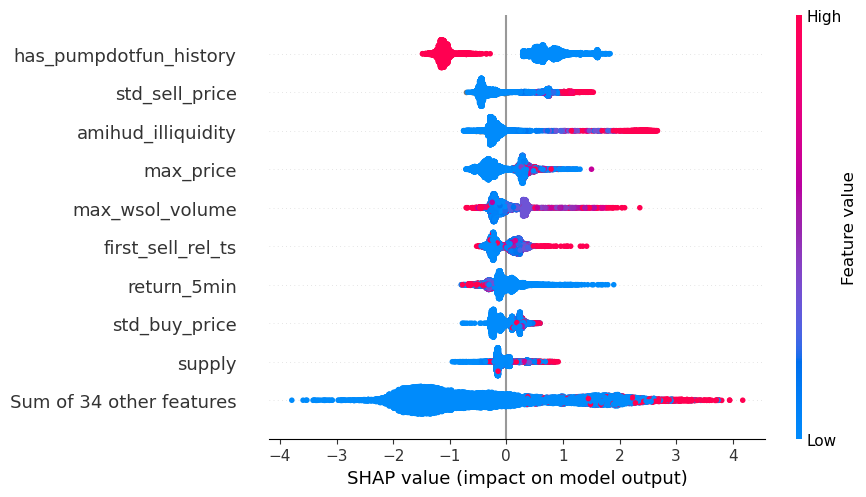

idle_300
[Benchmark]
Already trained.
	ROC AUC	= 0.8991014576505244
	PR AUC	= 0.9033343912363938
	F1	= 0.8115971107544141
[Expanded]
Already trained.
	ROC AUC	= 0.8986027514022698
	PR AUC	= 0.9029749246511394
	F1	= 0.8120044163404597
p-value of difference in:
	ROC AUC	= 0.4408073804790337
	PR AUC	= 0.624
	F1	= 0.8372


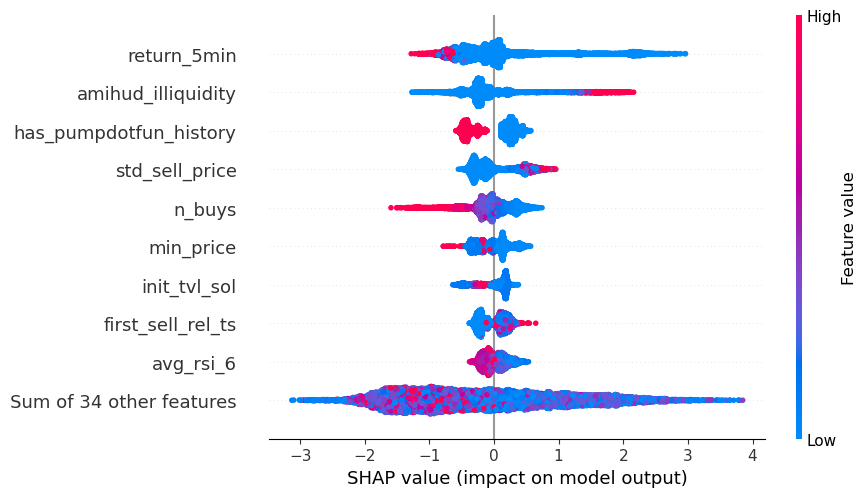

In [ ]:
from utils.catboost_training import cb_train_default
from utils.model_eval import print_metrics, compare_models


for target in targets:
    print(target)

    print("[Benchmark]")
    model_bench, prediction_bench = cb_train_default(
        X_bench_train, X_bench_test, y_train[target], f"bench_{target}", SEED
    )
    print_metrics(y_test[target], prediction_bench)

    print("[Expanded]")
    model_exp, prediction_exp = cb_train_default(
        X_exp_train, X_exp_test, y_train[target], f"exp_{target}", SEED
    )
    print_metrics(y_test[target], prediction_exp)

    compare_models(y_test[target], prediction_bench, prediction_exp, SEED)

    explainer = shap.TreeExplainer(model_exp)
    shap_values = explainer(X_exp_test)
    # shap.plots.beeswarm(shap_values[:,mm_features])
    shap.plots.beeswarm(shap_values)

## 2.2. Random Forest

md_price_no_post_rc_0.9_0.01
[Benchmark]
	ROC AUC	= 0.8614215738648038
	PR AUC	= 0.864304882379748
	F1	= 0.7808088313342533
[Expanded]
	ROC AUC	= 0.8636836655023629
	PR AUC	= 0.8666816835603663
	F1	= 0.7836830333368836
p-value of difference in:
	ROC AUC	= 0.047797811658348156
	PR AUC	= 0.0978
	F1	= 0.2626


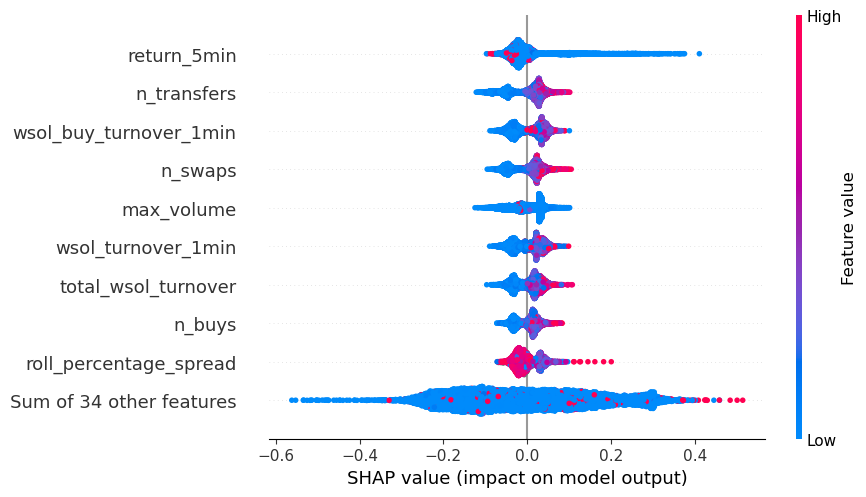

md_price_no_post_rc_0.99_0.005
[Benchmark]
	ROC AUC	= 0.9401784783548699
	PR AUC	= 0.8588835094342314
	F1	= 0.7768628238602129
[Expanded]
	ROC AUC	= 0.9414936875522327
	PR AUC	= 0.8599138659573109
	F1	= 0.7837190742218675
p-value of difference in:
	ROC AUC	= 0.08772981689865231
	PR AUC	= 0.5611
	F1	= 0.0488


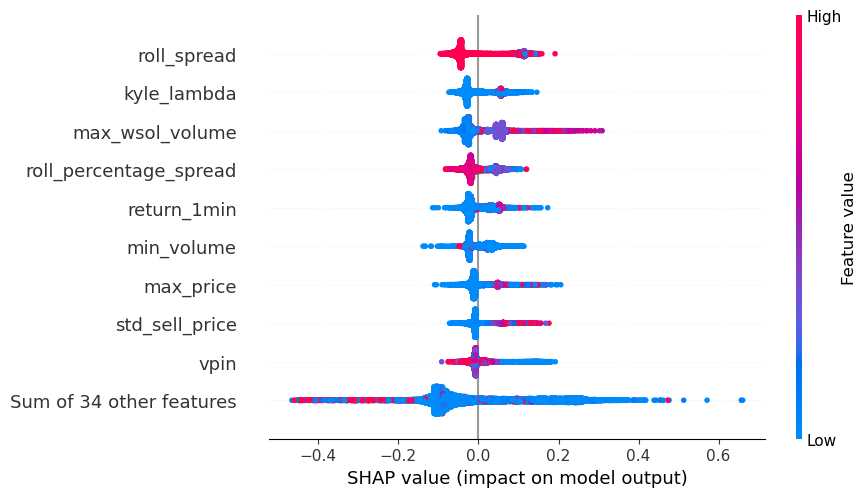

md_liq_no_post_rc_0.99_0.01
[Benchmark]
	ROC AUC	= 0.9681250361609735
	PR AUC	= 0.9405730432197007
	F1	= 0.867593467404508
[Expanded]
	ROC AUC	= 0.9682410150642438
	PR AUC	= 0.9417767453579466
	F1	= 0.8685776095186587
p-value of difference in:
	ROC AUC	= 0.7870449001792524
	PR AUC	= 0.3649
	F1	= 0.6989


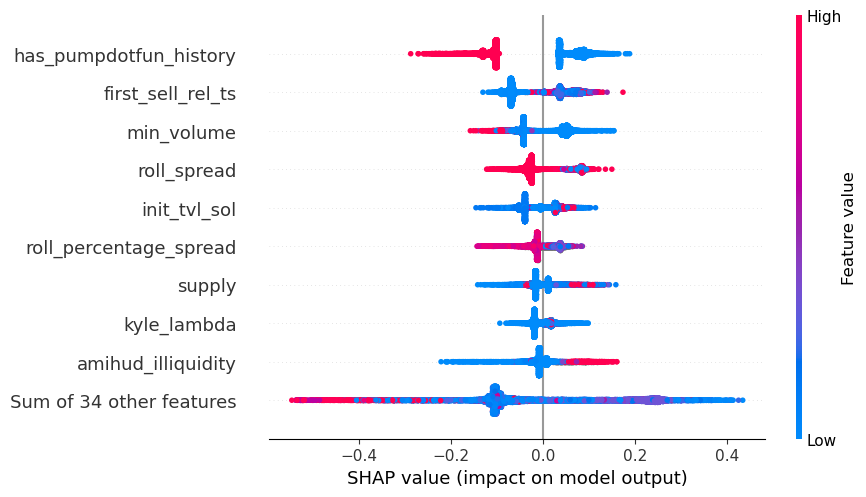

md_liq_0.9
[Benchmark]
	ROC AUC	= 0.9592815018430549
	PR AUC	= 0.9408104813678642
	F1	= 0.8617410387710315
[Expanded]
	ROC AUC	= 0.9601798304221211
	PR AUC	= 0.9429669855831895
	F1	= 0.8629702002931119
p-value of difference in:
	ROC AUC	= 0.10114372878163125
	PR AUC	= 0.0546
	F1	= 0.6015


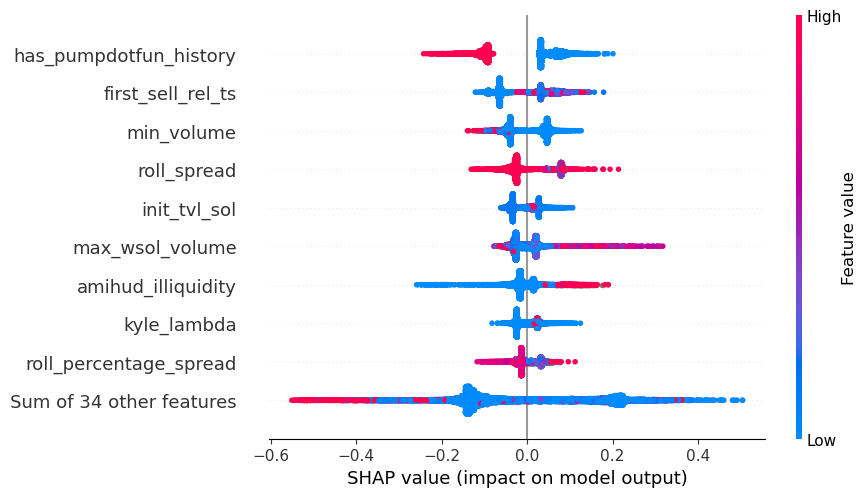

idle_300
[Benchmark]
	ROC AUC	= 0.8946415560653971
	PR AUC	= 0.898798031772414
	F1	= 0.8123114061557031
[Expanded]
	ROC AUC	= 0.8939738066017416
	PR AUC	= 0.8978778064165807
	F1	= 0.8131404460518384
p-value of difference in:
	ROC AUC	= 0.4475250896188804
	PR AUC	= 0.4262
	F1	= 0.6933


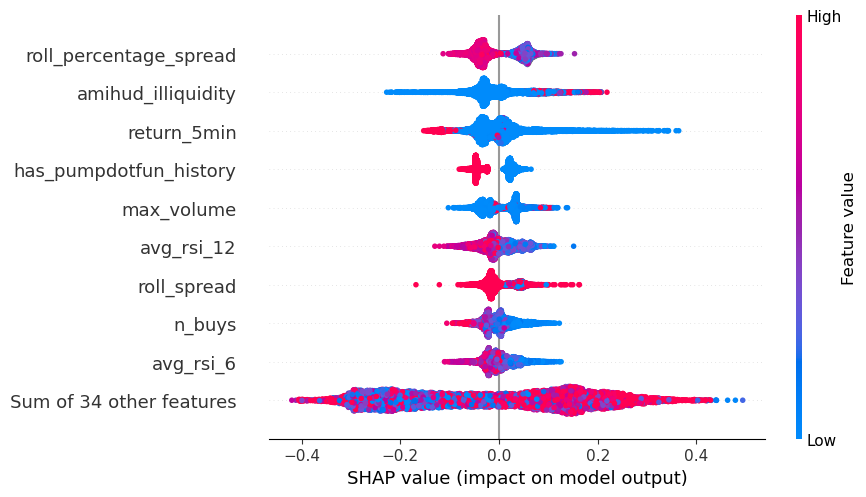

In [47]:
from utils.forest_training import rf_train_default


for target in targets:
    print(target)

    print("[Benchmark]")
    model_bench, prediction_bench = rf_train_default(
        X_bench_train, X_bench_test, y_train[target], f"bench_{target}", SEED
    )
    print_metrics(y_test[target], prediction_bench)

    print("[Expanded]")
    model_exp, prediction_exp = rf_train_default(
        X_exp_train, X_exp_test, y_train[target], f"exp_{target}", SEED
    )
    print_metrics(y_test[target], prediction_exp)

    compare_models(y_test[target], prediction_bench, prediction_exp, SEED)

    explainer = shap.TreeExplainer(model_exp)
    shap_values = explainer(X_exp_test, approximate=True)
    shap.plots.beeswarm(shap_values[:, :, 1])

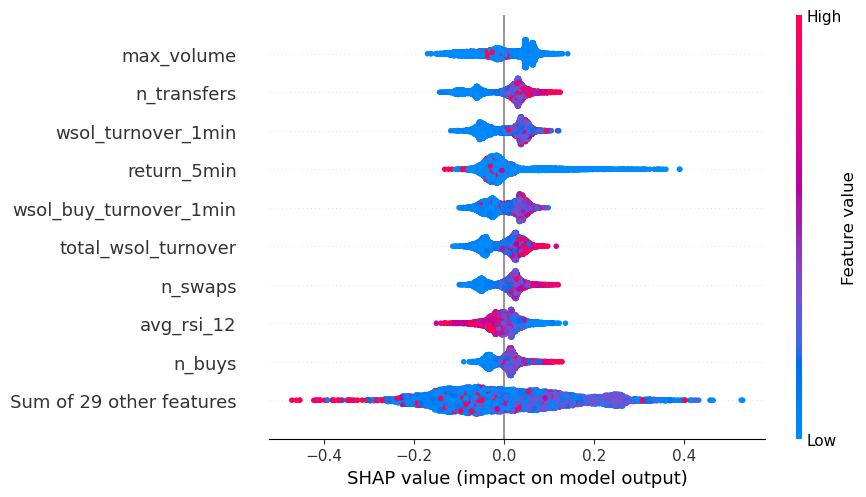

In [36]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=SEED)
model.fit(X_bench_train, y_train[targets[0]])

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_bench_test, approximate=True)
shap.plots.beeswarm(shap_values[:, :, 1])
# print(shap_values)

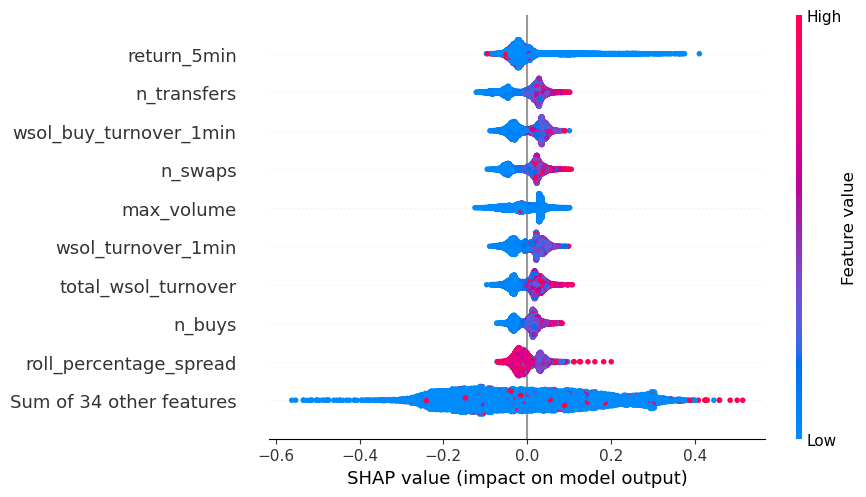

In [39]:
model = RandomForestClassifier(random_state=SEED)
model.fit(X_exp_train, y_train[targets[0]])

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_exp_test, approximate=True)
shap.plots.beeswarm(shap_values[:, :, 1])

# 3. With hyperparameter tuning

## 3.1. Catboost

Training for: md_price_no_post_rc_0.9_0.01
[Benchmark]
Already trained.
	ROC AUC	= 0.8714412163550442
	PR AUC	= 0.8774235537359926
	F1	= 0.7832675274783908
[Expanded]
Already trained.
	ROC AUC	= 0.8712966098212449
	PR AUC	= 0.8775932848786241
	F1	= 0.7810296945097202
p-value of difference in:
	ROC AUC	= 0.8430344523216268
	PR AUC	= 0.8143
	F1	= 0.2761


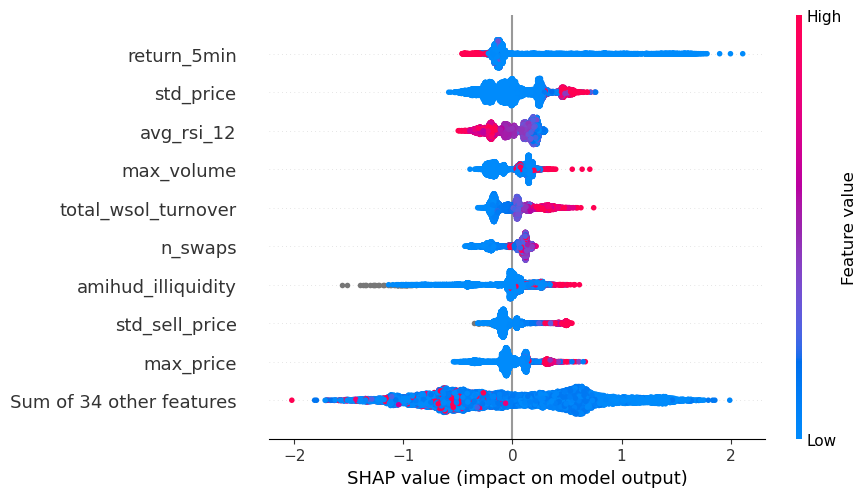

Training for: md_price_no_post_rc_0.99_0.005
[Benchmark]
Already trained.
	ROC AUC	= 0.9435752841659143
	PR AUC	= 0.8705973078950164
	F1	= 0.7840571088637716
[Expanded]
Already trained.
	ROC AUC	= 0.9454578961418816
	PR AUC	= 0.8740951665462324
	F1	= 0.7898593780946722
p-value of difference in:
	ROC AUC	= 4.38714392424478e-05
	PR AUC	= 0.0008
	F1	= 0.0532


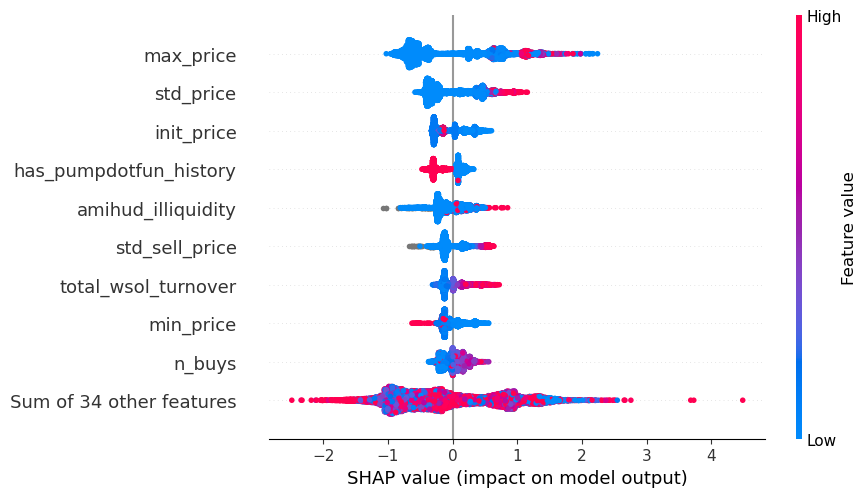

Training for: md_liq_no_post_rc_0.99_0.01
[Benchmark]
Already trained.
	ROC AUC	= 0.9702356719451867
	PR AUC	= 0.9490945520586442
	F1	= 0.8747351694915254
[Expanded]
Already trained.
	ROC AUC	= 0.9700650009434826
	PR AUC	= 0.9489898106336059
	F1	= 0.8716180371352785
p-value of difference in:
	ROC AUC	= 0.5680395717944405
	PR AUC	= 0.8427
	F1	= 0.067


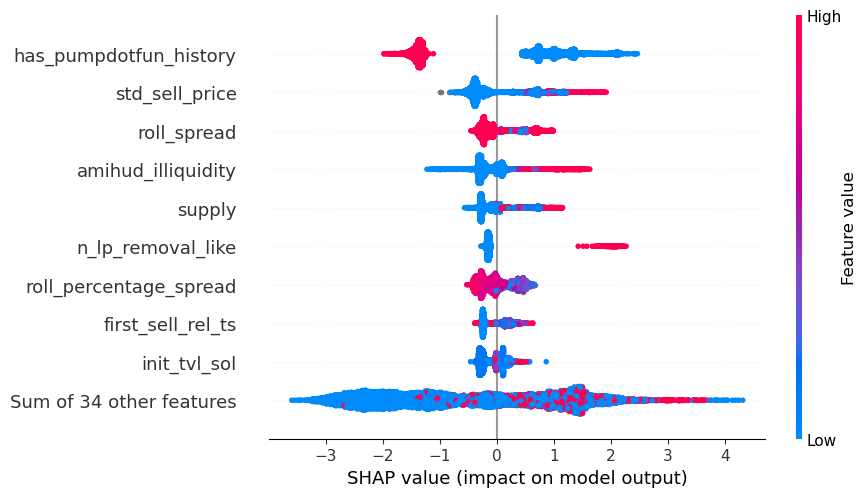

Training for: md_liq_0.9
[Benchmark]
Already trained.
	ROC AUC	= 0.9619946562142119
	PR AUC	= 0.9480757170382872
	F1	= 0.8643923758649994
[Expanded]
Already trained.
	ROC AUC	= 0.9627894065996799
	PR AUC	= 0.949417823865566
	F1	= 0.8657685831128218
p-value of difference in:
	ROC AUC	= 0.0600252280297636
	PR AUC	= 0.0387
	F1	= 0.5193


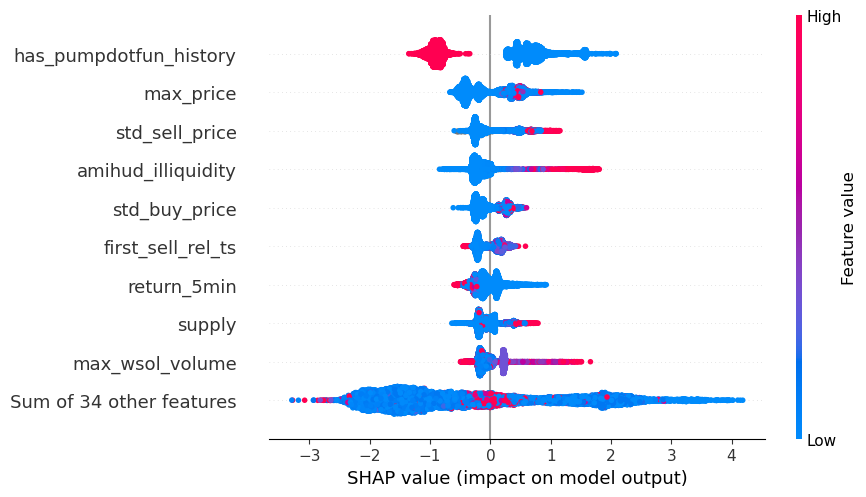

Training for: idle_300
[Benchmark]
Already trained.
	ROC AUC	= 0.9000514936697959
	PR AUC	= 0.9045214961065713
	F1	= 0.812987012987013
[Expanded]
Already trained.
	ROC AUC	= 0.9006218604352257
	PR AUC	= 0.9048143484789404
	F1	= 0.8127498001598721
p-value of difference in:
	ROC AUC	= 0.31117587564576576
	PR AUC	= 0.6514
	F1	= 0.8958


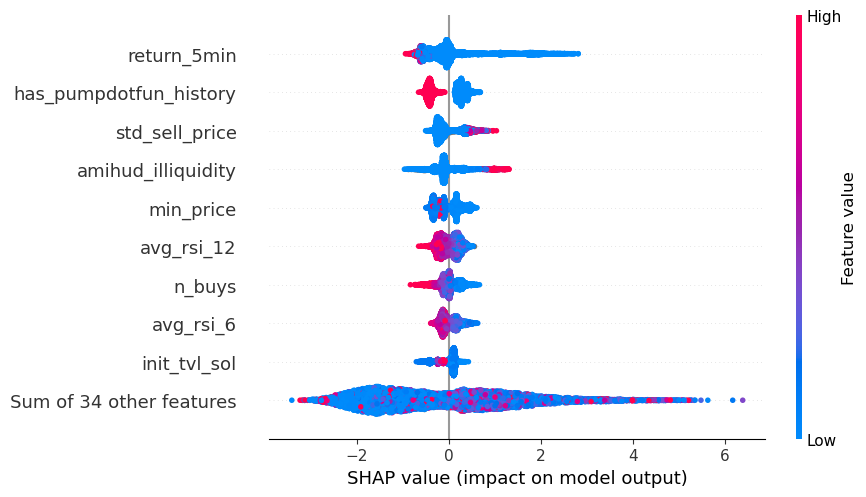

In [ ]:
from utils.catboost_training import cb_tune_and_train_standard

for target in targets:
    print(f"Training for: {target}")

    # benchmark
    print("[Benchmark]")
    model_bench, prediction_bench = cb_tune_and_train_standard(
        X_bench_train, X_bench_test, y_train[target], output_file=f"bench_{target}", seed=SEED
    )
    print_metrics(y_test[target], prediction_bench)

    # expanded
    print("[Expanded]")
    model_exp, prediction_exp = cb_tune_and_train_standard(
        X_exp_train, X_exp_test, y_train[target], output_file=f"exp_{target}", seed=SEED,
    )
    print_metrics(y_test[target], prediction_exp)

    # statistical significance
    compare_models(y_test[target], prediction_bench, prediction_exp, SEED)

    # shap
    explainer = shap.TreeExplainer(model_exp)
    shap_values = explainer(X_exp_test)
    shap.plots.beeswarm(shap_values)